In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math, time
import arch 
import json
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
#reading MarketWatch data rom a saved json
f = open('..\data\sentiments.json', encoding="utf8")
sen_data = json.load(f)
f.close()

In [3]:
price_data = pd.read_csv("..\data\\UNG.csv")

In [4]:
price_data = price_data.loc[price_data["Date"] <= "2024-04-29"].loc[price_data["Date"] >= "2015-07-14"].set_index("Date")

In [5]:
price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-14,222.240005,222.720001,216.639999,217.759995,217.759995,306288
2015-07-15,222.080002,224.800003,220.639999,223.039993,223.039993,398163
2015-07-16,222.399994,224.000000,218.399994,219.839996,219.839996,437625
2015-07-17,220.000000,221.759995,217.919998,221.759995,221.759995,222531
2015-07-20,215.520004,220.960007,215.039993,217.440002,217.440002,385106


In [6]:
price = price_data.reset_index()[["Close"]]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [130]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, look_back)

In [131]:
int(np.round(0.2*price_data.shape[0]))

443

In [132]:
price_data.shape[0] - 443

1771

In [133]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

# RNN

In [134]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [135]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [136]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [137]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0 or t == 1:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  1 MSE:  0.17941580712795258
Epoch  10 MSE:  0.05914606899023056
Epoch  20 MSE:  0.010291514918208122
Epoch  30 MSE:  0.006443767808377743
Epoch  40 MSE:  0.0028337775729596615
Epoch  50 MSE:  0.0021232457365840673
Epoch  60 MSE:  0.0019841170869767666
Epoch  70 MSE:  0.0018355485517531633
Epoch  80 MSE:  0.0017246085917577147
Epoch  90 MSE:  0.0016412708209827542


In [138]:
sns.set_style("whitegrid")

In [139]:
colors = sns.color_palette("icefire", 7).as_hex()
col1 = colors[3]
col2 = colors[5]

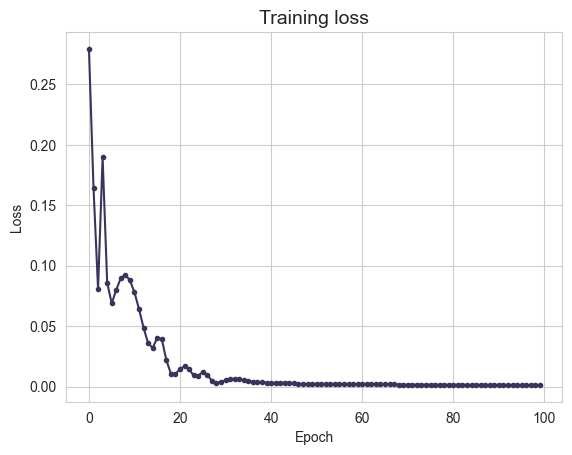

In [26]:
plt.plot(hist, color=colors[2], marker="o", markersize=3)
plt.title("Training loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [141]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.18 RMSE
Test Score: 5.32 RMSE


In [34]:
import matplotlib.dates as mdates

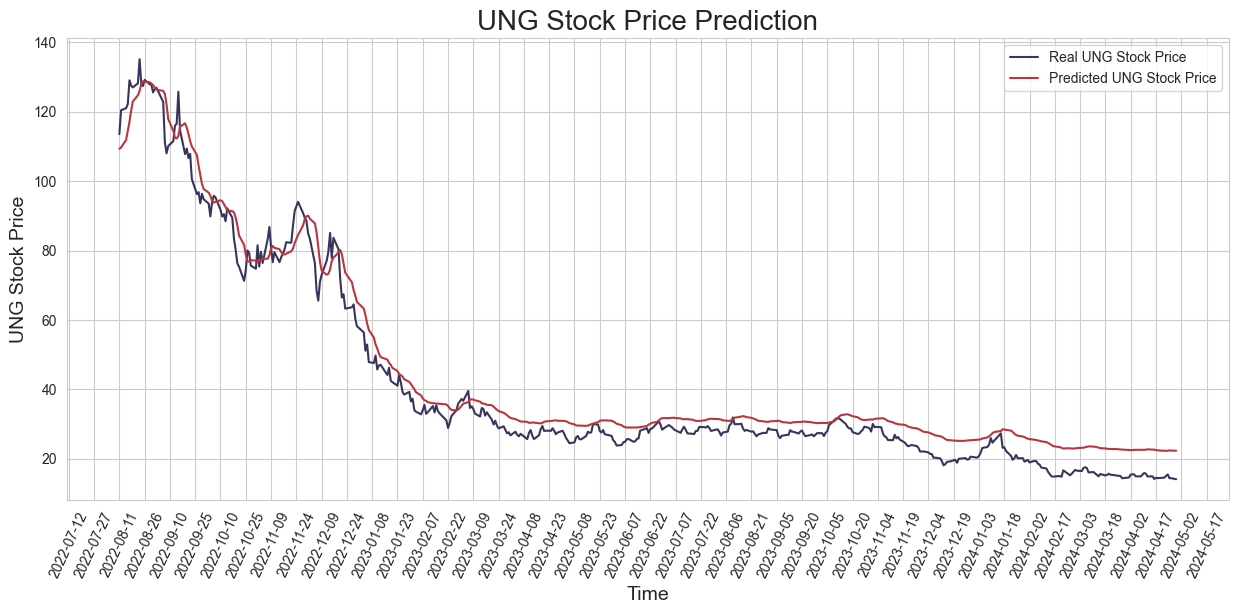

In [142]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

axes.plot(pd.to_datetime(price_data[len(price_data)-len(y_test):].index), y_test, color = colors[2], label = 'Real UNG Stock Price')
axes.plot(pd.to_datetime(price_data[len(price_data)-len(y_test):].index), y_test_pred, color = colors[5], label = 'Predicted UNG Stock Price')
plt.title('UNG Stock Price Prediction', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('UNG Stock Price', fontsize=14)
plt.legend()
plt.xticks(rotation=65)
plt.savefig('ung_pred.png', bbox_inches = 'tight')
plt.show()

# Strategy

Backtesting on test data for LSTM; checking conditions on the first day of every month and selling options whih expire on 3rd Friday of that month; assume strike to be the current price

In [94]:
def third_friday(year, month):
    """Return datetime.date for monthly option expiration given year and
    month
    """
    # The 15th is the lowest third day in the month
    third = datetime.date(year, month, 15)
    # What day of the week is the 15th?
    w = third.weekday()
    # Friday is weekday 4
    if w != 4:
        # Replace just the day (of month)
        third = third.replace(day=(15 + (4 - w) % 7))
    return third

In [95]:
start = datetime.date(2022, 8, 1) #first day of first month in test period
end = datetime.date(2024, 4, 1) #first day of last month in test period
n_months = (end.year - start.year) * 12 + (end.month - start.month)
selling_dates = [start + relativedelta(months=i) for i in range(n_months+1)]
exp_dates = [third_friday(x.year, x.month) for x in selling_dates]

In [96]:
# 5 is an offset for the few days of July that got into test data; automate in the future
x_test1 = x_test[5:]
y_test1 = y_test[5:]

In [97]:
returns = 100 * price_data["Adj Close"].pct_change().dropna()

## Period 1

(array([19207., 19209., 19211., 19213., 19215., 19217., 19219., 19221.,
        19223.]),
 [Text(19207.0, 0, '2022-08-03'),
  Text(19209.0, 0, '2022-08-05'),
  Text(19211.0, 0, '2022-08-07'),
  Text(19213.0, 0, '2022-08-09'),
  Text(19215.0, 0, '2022-08-11'),
  Text(19217.0, 0, '2022-08-13'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19221.0, 0, '2022-08-17'),
  Text(19223.0, 0, '2022-08-19')])

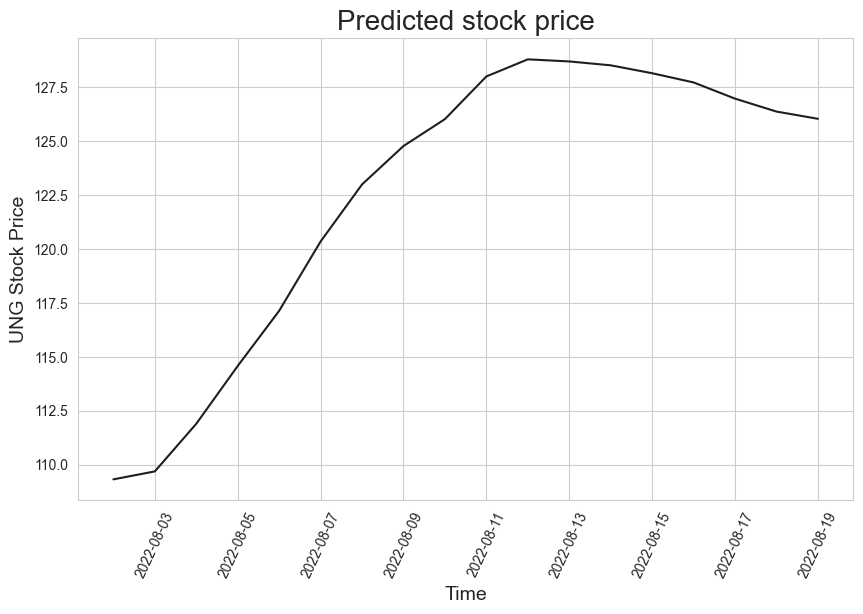

In [172]:
#------------------------predicting price with LSTM----------------------------
#need a way of automating analysis, but for now just running step by step to inspect anually
i = 0
delta1 = selling_dates[i] - start
delta2 = exp_dates[i] - start
x_cur  = x_test[delta1.days:delta2.days]
y_pred = model(x_cur)
y_pred = scaler.inverse_transform(y_pred.detach().numpy())

figure, axes = plt.subplots(figsize=(10, 6))
plt.plot(pd.date_range(start=selling_dates[i] + datetime.timedelta(days=1), end=exp_dates[i]), np.array(y_pred).flatten(), color=col1)
plt.title('Predicted stock price', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('UNG Stock Price', fontsize=14)
plt.xticks(rotation=65)
#plt.savefig("period1_lstm.png", bbox_inches = 'tight')

In [106]:
#------------------------GARCH---------------------------------
am = arch.arch_model(returns[:str(selling_dates[i])], vol="Garch", p=3, o=0, q=2, dist="Normal")
res = am.fit(update_freq=5)
delta3 = exp_dates[i] - selling_dates[i]
forecasts = res.forecast(horizon=delta3.days)

Iteration:      5,   Func. Count:     49,   Neg. LLF: 4283.103812541764
Iteration:     10,   Func. Count:     94,   Neg. LLF: 4257.162238519424
Iteration:     15,   Func. Count:    136,   Neg. LLF: 4256.829100865152
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4256.828166576163
            Iterations: 20
            Function evaluations: 182
            Gradient evaluations: 19


In [104]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4257.21
Distribution:                  Normal   AIC:                           8526.41
Method:            Maximum Likelihood   BIC:                           8559.30
                                        No. Observations:                 1775
Date:                Sat, May 11 2024   Df Residuals:                     1774
Time:                        13:26:20   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0179  5.243e-02     -0.342      0.732 [ -0.121,8.484e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0899  4.425e-02      2.031  4.222e-02  [3.158e-03,  0.177]
alpha[1]       0.0556  2.923e-02      1.901  5.726e-02 [-1.713e-03,  0.113]
alpha[2]       0.0851  3.665e-02      2.322  2.026e-02  [1.325e-02,  0.157]
beta[1]        0.4381      0.243      1.803  7.133e-02 [-3.805e-02,  0.914]
beta[2]        0.4211      0.222      1.898  5.772e-02 [-1.379e-02,  0.856]
===========================================================================

Covariance estimator: robust
"""

In [155]:
print(forecasts.mean)

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414   

                h.13      h.14      h.15      h.16      h.17      h.18  
Date                                                                    
2022-08-01 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414 -0.017414  


In [150]:
print(forecasts.variance)

                h.01       h.02      h.03       h.04      h.05       h.06  \
Date                                                                        
2022-08-01  20.56242  20.105912  19.59838  20.216508  19.77206  20.274964   

                 h.07       h.08       h.09       h.10       h.11       h.12  \
Date                                                                           
2022-08-01  19.936266  20.345025  20.089928  20.424412  20.235256  20.511151   

                 h.13       h.14       h.15       h.16       h.17       h.18  
Date                                                                          
2022-08-01  20.374005  20.603683  20.507558  20.700778  20.637009  20.801468  


In [154]:
print(forecasts.residual_variance)

                 h.01       h.02       h.03       h.04       h.05       h.06  \
Date                                                                           
2022-08-01  20.560726  20.610606  20.660468  20.710312  20.760138  20.809947   

                 h.07      h.08       h.09       h.10       h.11       h.12  \
Date                                                                          
2022-08-01  20.859737  20.90951  20.959266  21.009003  21.058723  21.108425   

                 h.13       h.14       h.15       h.16      h.17       h.18  
Date                                                                         
2022-08-01  21.158109  21.207776  21.257425  21.307056  21.35667  21.406266  


In [151]:
#-------------------Sentiment Analysis------------------------
sent_df = pd.DataFrame(sen_data, columns=["Title", "Date", "Sentiment"])
sent_df["Date"] = pd.to_datetime(sent_df["Date"]).dt.date

C:\Users\atevs\AppData\Local\Temp\ipykernel_19000\1269568977.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"], color=col2)


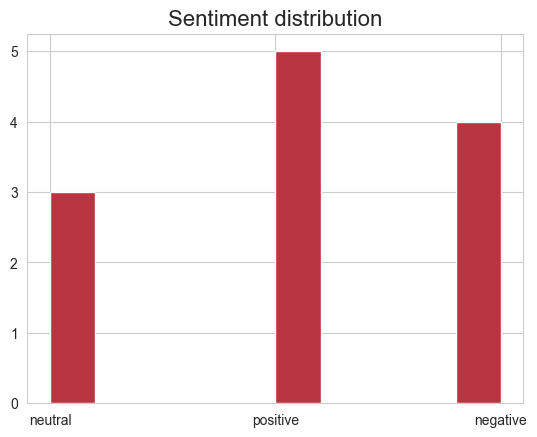

In [158]:
plt.hist(sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"], color=col2)
plt.title("Sentiment distribution", fontsize=16)
plt.savefig("sent1.png", bbox_inches = 'tight')

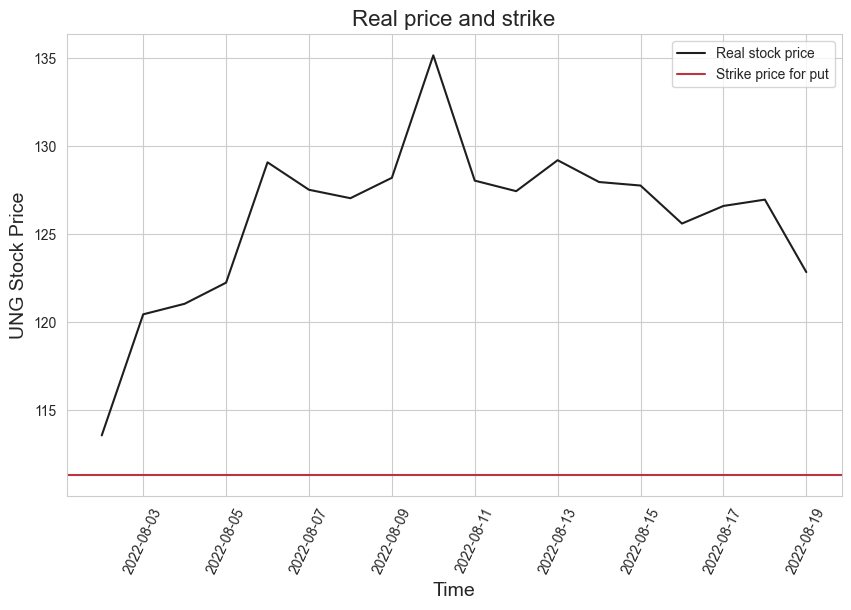

In [173]:
#-------------------Result------------------------
figure, axes = plt.subplots(figsize=(10, 6))
plt.plot(pd.date_range(start=selling_dates[i] + datetime.timedelta(days=1), end=exp_dates[i]), y_test[delta1.days:delta2.days], color=col1, label="Real stock price")
plt.axhline(0.98*y_test[delta1.days], color=col2, linestyle='-', label="Strike price for put")
plt.title("Real price and strike", fontsize=16)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('UNG Stock Price', fontsize=14)
plt.xticks(rotation=65)
plt.savefig("put1.png", bbox_inches = 'tight')

Accourding to our strategy, we would sell a put option with a strike equal to the current price and it would expire out-of-the-money

## Period 2

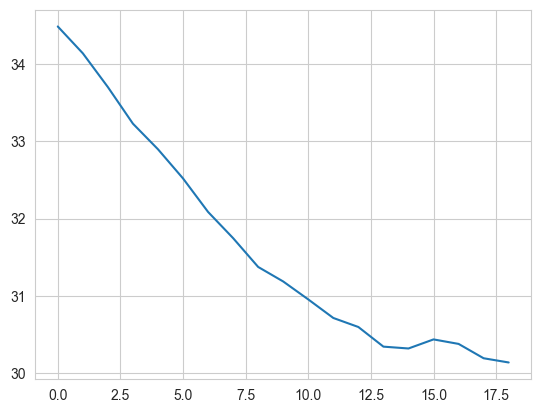

In [284]:
#------------------------predicting price with LSTM----------------------------
#need a way of automating analysis, but for now just running step by step to inspect anually
i = 5
delta1 = selling_dates[i] - start
delta2 = exp_dates[i] - start
x_cur  = x_test[delta1.days:delta2.days]
y_pred = model(x_cur)
y_pred = scaler.inverse_transform(y_pred.detach().numpy())
plt.plot(np.array(y_pred).flatten())

In [285]:
#------------------------GARCH---------------------------------
am = arch.arch_model(returns[:str(selling_dates[i])], vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)
delta3 = exp_dates[i] - selling_dates[i]
forecasts = res.forecast(horizon=delta3.days)

Iteration:      5,   Func. Count:     33,   Neg. LLF: 4574.213271813542
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4573.187444081126
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4573.187368137469
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12


In [286]:
print(forecasts.mean)

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2022-12-30 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573   

                h.07      h.08      h.09      h.10      h.11      h.12  \
Date                                                                     
2022-12-30 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573   

                h.13      h.14      h.15      h.16      h.17      h.18  \
Date                                                                     
2022-12-30 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573 -0.025573   

                h.19  
Date                  
2022-12-30 -0.025573  


In [287]:
print(forecasts.variance)

                 h.01       h.02       h.03       h.04       h.05       h.06  \
Date                                                                           
2022-12-30  29.564019  29.619189  29.674358  29.729528  29.784697  29.839866   

                 h.07       h.08       h.09       h.10       h.11       h.12  \
Date                                                                           
2022-12-30  29.895036  29.950205  30.005375  30.060544  30.115713  30.170883   

                 h.13       h.14       h.15      h.16      h.17       h.18  \
Date                                                                         
2022-12-30  30.226052  30.281222  30.336391  30.39156  30.44673  30.501899   

                 h.19  
Date                   
2022-12-30  30.557069  


In [288]:
print(forecasts.residual_variance)

                 h.01       h.02       h.03       h.04       h.05       h.06  \
Date                                                                           
2022-12-30  29.564019  29.619189  29.674358  29.729528  29.784697  29.839866   

                 h.07       h.08       h.09       h.10       h.11       h.12  \
Date                                                                           
2022-12-30  29.895036  29.950205  30.005375  30.060544  30.115713  30.170883   

                 h.13       h.14       h.15      h.16      h.17       h.18  \
Date                                                                         
2022-12-30  30.226052  30.281222  30.336391  30.39156  30.44673  30.501899   

                 h.19  
Date                   
2022-12-30  30.557069  


In [289]:
#-------------------Sentiment Analysis------------------------
sent_df = pd.DataFrame(sen_data, columns=["Title", "Date", "Sentiment"])
sent_df["Date"] = pd.to_datetime(sent_df["Date"]).dt.date

C:\Users\atevs\AppData\Local\Temp\ipykernel_19000\2250814774.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()


<Axes: >

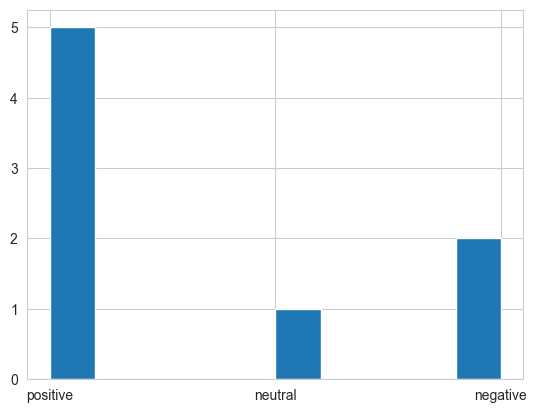

In [290]:
sent_df[sent_df["Date"] >= selling_dates[i] + datetime.timedelta(days=-3)][sent_df["Date"] <= selling_dates[i]]["Sentiment"].hist()

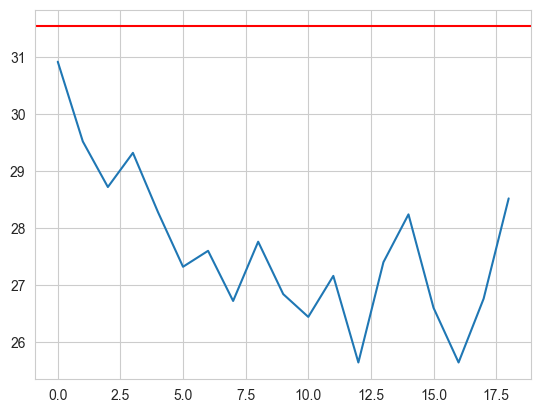

In [291]:
#-------------------Result------------------------
plt.plot(y_test[delta1.days:delta2.days])
plt.axhline(1.02*y_test[delta1.days], color='r', linestyle='-')

Accourding to our strategy, we would sell a call option with a strike equal to the current price and it would be in-of-the-money next day